## Load and join tables

In [10]:
import pandas as pd

PROFILES = "/Users/shanglinghsu/7cups-analysis/profiles.csv"
CHAT_RESPONSES = "/Users/shanglinghsu/7cups-analysis/Chat Questionnaire (Responses) - Form Responses 1.tsv"
EXP_RESPONSES = "/Users/shanglinghsu/7cups-analysis/Experiment Questionnaire (Responses) - Form Responses 1.tsv"
PARTICIPANTS = "/Users/shanglinghsu/Library/CloudStorage/OneDrive-GeorgiaInstituteofTechnology/7 Cups Participants.xlsx"
LOG_PATH = "/Users/shanglinghsu/backup_logs/flask_outputs_20221202"

participants = pd.read_excel(PARTICIPANTS)
participants = participants[participants["Username"].notna()]  # Filter mock interivews
participants = participants[participants["Category Chosen"].notna()]  # Filter no-show and no responses
participants["user_id"] = participants["user_id"].astype(pd.Int16Dtype(), copy=False)
participants.reset_index(inplace=True)
participants["Participant Index"] = participants.index + 1
NUM_PARTICIPANTS = len(participants)

profiles = pd.read_csv(PROFILES, header=0, index_col=0)
exp_responses = pd.read_csv(EXP_RESPONSES, header=0, sep="\t")
chat_responses = pd.read_csv(CHAT_RESPONSES, header=0, sep="\t")
chats = pd.read_csv(LOG_PATH + ".csv", header=0)

## User table

In [11]:
# Can't join() due to poor support of join() on string dtype
def left_join_in_place(left, right, left_on, right_on, rprefix):
    for column in right.columns:
        if column == right_on: continue
        mask, values = [], []
        for i, x in enumerate(left[left_on]):
            mask = right[right_on] == x
            if any(mask):
                values.append(right[column][mask].iloc[0])
            elif rprefix + column in left.columns:
                values.append(left[rprefix + column].loc[i])
            else:
                values.append(pd.NA)
        left[rprefix + column] = values
    return left

EXP_PREFIX = "EXP_"
left_join_in_place(participants, profiles, "Username", "Username", "")
left_join_in_place(participants, exp_responses, "user_id", "What is the 3-digit User ID for this experiment?", EXP_PREFIX)

# Alias for readability
participants["Category Confidence"] = participants[[col for col in participants.columns if "confident" in col][0]]

### Convert user attributes to numeric and binary values

In [12]:
from datetime import datetime
BIN_PREFIX = "BIN_"
NUM_PREFIX = "NUM_"

def add_convert_column(df, prefix, field, callback):
    df[prefix + field] = df[field].apply(callback)

### Control variables

In [13]:
add_convert_column(participants, BIN_PREFIX, "Counseling Background", lambda x: 1 if x else 0)
add_convert_column(participants, BIN_PREFIX, 'show_suggestion_first', lambda x: 1 if x else 0)
participants["Counseling Background"][participants["Counseling Background"].isna()] = 0.5

/var/folders/sh/npz3g13d7xv_cgxh2rjw81_w0000gn/T/ipykernel_7935/1917026257.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants["Counseling Background"][participants["Counseling Background"].isna()] = 0.5


### Profiles

In [14]:
add_convert_column(participants, NUM_PREFIX, "Listener Rating", lambda x: float(x.split()[0]))
add_convert_column(participants, NUM_PREFIX, "Progress Path", lambda x: int(x.split()[1].replace(",", "")))
add_convert_column(participants, "OBJ_", "Listener Since", lambda x: datetime.strptime(x, "%b %d, %Y"))
add_convert_column(participants, NUM_PREFIX, "Listener Since", lambda x: (datetime.strptime(x, "%b %d, %Y") - datetime.now()).days)

NUM_COL_PROFILES = [
    "NUM_Listener Rating", 
    "NUM_Progress Path", 
    "NUM_Listener Since",
    "Number of Ratings:",
    "Number of Reviews:",
    "Cheers",
    "People Helped",
    "Chats",
    "Group Support Chats",
    "Listener Group Chats",
    "Forum Posts",
    "Forum Upvotes",
]
print(participants["Chats"].describe()[["min", "max"]])
print(participants["NUM_Listener Since"].describe()[["min", "max"]])

min       25.0
max    33255.0
Name: Chats, dtype: float64
min   -3141.0
max     -55.0
Name: NUM_Listener Since, dtype: float64


### Exp Responses

In [15]:
FREQ_MAP_NUM = {
    "Never": 0,
    "Very Rarely": 1,
    "Rarely": 2,
    "Occasionally": 3,
    "Frequently": 4,
    "Very Frequently": 5,
}
AGREE_MAP_NUM = {
    "Strongly Disagree": 0,
    "Disagree": 1,
    "Undecided": 2,
    "Agree": 3,
    "Strongly Agree": 4,
}
PROB_MAP_NUM = {
    "Very Probably Not": 0,
    "Probably Not": 1,
    "Possibly": 2,
    "Probably": 3,
    "Very Probably": 4,
    "Definitely": 5,
}
###############################################################################
FREQ_MAP_BIN = {
    "Never": 0,
    "Very Rarely": 0,
    "Rarely": 0,
    "Occasionally": 1,
    "Frequently": 1,
    "Very Frequently": 1,
}
AGREE_MAP_BIN = {
    "Strongly Disagree": 0.0,
    "Disagree": 0.0,
    "Undecided": 0.5,
    "Agree": 1.0,
    "Strongly Agree": 1.0,
}
PROB_MAP_BIN = {
    "Very Probably Not": 0,
    "Probably Not": 0,
    "Possibly": 0,
    "Probably": 1,
    "Very Probably": 1,
    "Definitely": 1,
}
###############################################################################
FREQ_OPTIONS = [
    "Never",
    "Very Rarely",
    "Rarely",
    "Occasionally",
    "Frequently",
    "Very Frequently",
]
AGREE_OPTIONS = [
    "Strongly Disagree",
    "Disagree",
    "Undecided",
    "Agree",
    "Strongly Agree",
]
PROB_OPTIONS = [
    "Very Probably Not",
    "Probably Not",
    "Possibly",
    "Probably",
    "Very Probably",
    "Definitely",
]

In [16]:
harmful_cols = [col for col in participants.columns if col.startswith(EXP_PREFIX) and "harmful" in col]
use_cols = [col for col in participants.columns if col.startswith(EXP_PREFIX) and "make use of" in col]
freq_cols = [col for col in participants.columns if col.startswith(EXP_PREFIX) and ("often" in col and col not in harmful_cols + use_cols)]
agree_cols = [col for col in participants.columns if col.startswith(EXP_PREFIX) and "As a whole" in col and "reliable" not in col]
prob_cols = [col for col in participants.columns if col.startswith(EXP_PREFIX) and "will you" in col]
checkbox_cols = [col for col in participants.columns if col.startswith(EXP_PREFIX) and ("What do you" in col or "more when" in col)]
demo_cols = [col for col in participants.columns if col.startswith(EXP_PREFIX) and ("age" in col or "preferred pronoun(s)" in col or "device" in col)]
open_cols = [col for col in participants.columns if col.startswith(EXP_PREFIX) and (col == 'EXP_Any other comments?' or "like about" in col or "helps more" in col)]
confident_cols = [col for col in participants.columns if "Confidence" in col]

# unused coloumns
used_cols = harmful_cols + use_cols + freq_cols + agree_cols + prob_cols + checkbox_cols + demo_cols + open_cols + confident_cols
[col for col in participants.columns if col.startswith(EXP_PREFIX) and col not in used_cols]

['EXP_Timestamp',
 'EXP_How confident are you about listening in the category you selected, such as relationship stress or anxiety?',
 'EXP_As a whole, was the tool... [reliable?]']

In [17]:
for column in freq_cols + use_cols:
    add_convert_column(participants, NUM_PREFIX, column, lambda x: FREQ_MAP_NUM[x])
    add_convert_column(participants, BIN_PREFIX, column, lambda x: FREQ_MAP_BIN[x])
for column in agree_cols:
    add_convert_column(participants, NUM_PREFIX, column, lambda x: AGREE_MAP_NUM[x])
    add_convert_column(participants, BIN_PREFIX, column, lambda x: AGREE_MAP_BIN[x])
for column in prob_cols:
    add_convert_column(participants, NUM_PREFIX, column, lambda x: PROB_MAP_NUM[x])
    add_convert_column(participants, BIN_PREFIX, column, lambda x: PROB_MAP_BIN[x])

In [18]:
participants.to_csv("participants_table.csv")

## Chat table
To get from `participants`:
- participant user_id
- category
- order
- with tool or not

In [19]:
participants_chat_df = participants[[col for col in participants.columns if ("id_" in col) or ("ategory" in col) or ("first" in col) or ("user_id" in col)]]

CAT_COL = "Choose Anxiety"
participants_chat_df[CAT_COL] = participants_chat_df["Category Chosen"].apply(lambda x: 1 if x == "A" else 0)

left_join_in_place(chats, participants_chat_df, "chat_id", "chat_id_1", "")
left_join_in_place(chats, participants_chat_df, "chat_id", "chat_id_2", "")
ORDER_COL = "Order"
chats[ORDER_COL] = [0] * len(chats)
chats.loc[chats["chat_id_2"].isna(), ORDER_COL] = 2
chats.loc[chats["chat_id_1"].isna(), ORDER_COL] = 1

SHOW_COL = "Show Suggestions"
chats[SHOW_COL] = [0] * len(chats)
chats.loc[(chats[ORDER_COL] == 1) & (chats["show_suggestion_first"] > 0.5), SHOW_COL] = 1
chats.loc[(chats[ORDER_COL] == 2) & (chats["show_suggestion_first"] < 0.5), SHOW_COL] = 1
chats.head(5)

chats = chats[list(filter(lambda x: ("_1" not in x) and ("_2" not in x) and (EXP_PREFIX not in x) and ("show_suggestion_first" not in x), chats.columns))]
left_join_in_place(chats, chat_responses, "chat_id", "What is the 3-letter Chat ID for this chat?", "")
chats = chats.sort_values(by=['datetime'])

chats = chats[list(filter(lambda x: ((not any(chats[x].isna())) or x.startswith("Any")), chats.columns))]

chats.to_csv("chats_table.csv")

/var/folders/sh/npz3g13d7xv_cgxh2rjw81_w0000gn/T/ipykernel_7935/1856179558.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  participants_chat_df[CAT_COL] = participants_chat_df["Category Chosen"].apply(lambda x: 1 if x == "A" else 0)


## Demographic

In [20]:
participants['EXP_What is your age?'].describe()[["min", "max", "mean", "std"]]

min     18.000000
max     69.000000
mean    36.333333
std     16.391054
Name: EXP_What is your age?, dtype: float64

In [21]:
from collections import Counter
Counter(participants['Gender'])

Counter({'Female': 11, 'Male': 3, nan: 1})

## Experiment Questionnaire

In [22]:
import os
if not os.path.isdir("figures"):
    os.mkdir("figures")

In [2]:
from matplotlib import font_manager

l = font_manager.findSystemFonts(fontpaths=p, fontext="ttf")
sorted([x.replace(p, "") for x in l])

['CALIBRIB.TTF',
 'CALIBRII.TTF',
 'CALIBRIZ.TTF',
 'Calibri.ttf',
 'Carlito-Bold.ttf',
 'Carlito-BoldItalic.ttf',
 'Carlito-Italic.ttf',
 'Carlito-Regular.ttf',
 'DejaVuSans-Bold.ttf',
 'DejaVuSans-BoldOblique.ttf',
 'DejaVuSans-Oblique.ttf',
 'DejaVuSans.ttf',
 'DejaVuSansDisplay.ttf',
 'DejaVuSansMono-Bold.ttf',
 'DejaVuSansMono-BoldOblique.ttf',
 'DejaVuSansMono-Oblique.ttf',
 'DejaVuSansMono.ttf',
 'DejaVuSerif-Bold.ttf',
 'DejaVuSerif-BoldItalic.ttf',
 'DejaVuSerif-Italic.ttf',
 'DejaVuSerif.ttf',
 'DejaVuSerifDisplay.ttf',
 'STIXGeneral.ttf',
 'STIXGeneralBol.ttf',
 'STIXGeneralBolIta.ttf',
 'STIXGeneralItalic.ttf',
 'STIXNonUni.ttf',
 'STIXNonUniBol.ttf',
 'STIXNonUniBolIta.ttf',
 'STIXNonUniIta.ttf',
 'STIXSizFiveSymReg.ttf',
 'STIXSizFourSymBol.ttf',
 'STIXSizFourSymReg.ttf',
 'STIXSizOneSymBol.ttf',
 'STIXSizOneSymReg.ttf',
 'STIXSizThreeSymBol.ttf',
 'STIXSizThreeSymReg.ttf',
 'STIXSizTwoSymBol.ttf',
 'STIXSizTwoSymReg.ttf',
 'cmb10.ttf',
 'cmex10.ttf',
 'cmmi10.ttf',
 'cmr

### Likert scales

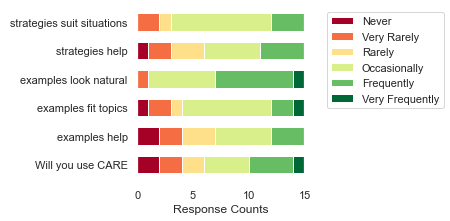

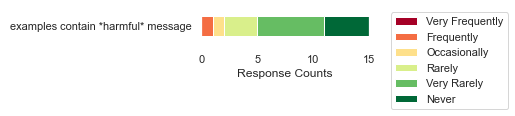

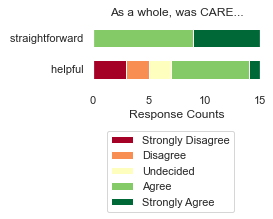

In [125]:
import pandas as pd
import matplotlib.pyplot as plt

def reformat_question(question, title):
    question = question.replace(" [-]", "").replace(EXP_PREFIX, "").replace("...", "").replace("[", "").replace("]", "")
    question = question.replace("If the tool is provided to you, how often do you think you will make use of it?", "Will you use CARE?")
    question = question.replace("suggested strategies (blue hints)", "strategies")
    question = question.replace("example responses (white buttons)", "examples")
    question = question.replace(" suit the situation", " suit situations")
    question = question.replace(" fit the conversation topic", " fit topics")
    question = question.replace(" to use", "")
    question = question.replace(" on 7 Cups", "")
    question = question.replace(title.replace("...", ""), "")
    return question

def plot_responses(cols, options, title, filename, show_legend=True, legend_anchor=(1.1, 1.0)):
    cols = cols[::-1]
    count_df = pd.DataFrame(data={}, columns=options)
    for option in options:
        count_df[option] = (participants[cols] == option).sum()

    count_df.plot(
        kind='barh', 
        stacked=True, 
        cmap="RdYlGn",
        width=0.6,
        figsize=(3, 0.5 * len(cols) + 0.2),
        xlim=(0, 15),
        legend=show_legend,
    )
    plt.yticks(range(0,len(count_df.index)), list(map(lambda x: reformat_question(x, title).replace("?", ""), count_df.index))) # not working dunno why
    plt.xlabel('Response Counts')
    title = title.replace("the tool", "CARE").replace("This tool", "CARE")
    if "how often did the" not in title.lower():
        plt.title(title)
    if show_legend:
        plt.legend(loc="upper left", bbox_to_anchor=legend_anchor)
    # plt.vlines(x=7.5, ymin=-1, ymax=len(count_df)-0.5, color='darkgrey', linestyles='dashed')  # dashed median line
    plt.savefig("figures/" + filename + ".svg")

plot_responses(freq_cols + use_cols, FREQ_OPTIONS, "How often did the...", "tool-quality")
plot_responses(harmful_cols, FREQ_OPTIONS[::-1], 'How often did the...', "harmful")
plot_responses(agree_cols, AGREE_OPTIONS, "As a whole, was the tool...", "was-the-tool", legend_anchor=(0.05, -0.6))
# plot_responses(use_cols, FREQ_OPTIONS, "If the tool is provided to you, how often do you think you will make use of it?", "make-use")
# plot_responses(prob_cols, PROB_OPTIONS, "If you can switch the tool on and off as you like, will you switch it on?", "switch")

### Checkboxes

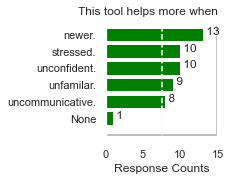

In [156]:
from collections import Counter
from matplotlib.pyplot import figure

def get_default_option_count(col):
    flattened_selections = [b for a in participants[col].apply(lambda x: x.split(", ")) for b in a]
    flattened_selections = list(map(lambda x: "None of the above" if "none" in x.lower() else x, flattened_selections))
    counts = list(Counter(flattened_selections).items())
    counts.sort(key=lambda x: x[1])
    counts = list(filter(lambda x: x[0] == "None of the above" or x[1] > 1, counts))
    count_df = pd.DataFrame(data=counts, columns=["Selection", "Count"])
    return count_df

def transform_ckbx1(text):
    text = text.replace(" the overall quality of your responses", " quality")
    text = text.replace(" listeners of counseling", "")
    text = text.replace(" better", "")
    text = text.replace(" listeners'", "")
    text = text.replace(" decision", "")
    text = text.replace(" of the above", "")
    return text
def transform_ckbx2(text):
    text = text.replace(" the overall quality of your responses", " quality")
    text = text.replace(" in listener-member communication", "")
    text = text.replace(" the diversity of", "")
    text = text.replace(" more", "")
    text = text.replace(" examples", "")
    text = text.replace(" the variety of counseling", "")
    text = text.replace(" of the above", "")
    return text

def transform_ckbx3(text):
    text = text.replace("the Listener is newer to Listening chats", "newer")
    text = text.replace("the Listener feels more stressed", "stressed")
    text = text.replace("the Listener is less confident in the chat's category", "unconfident")
    text = text.replace("the Listener is less familiar with the Member's chief complaint", "unfamilar")
    text = text.replace("the Member is less communicative", "uncommunicative")
    text = text.replace(" of the above", "")
    return text

def plot_checkboxes(col, color, filename, transform):
    count_df = get_default_option_count(col)
    fig, ax = plt.subplots()
    fig.set_size_inches(2, len(count_df) * 0.2 + 1)
    count_df["Selection_"] = count_df["Selection"].apply(lambda x: transform(x))
    ax.barh(
        width=count_df["Count"],
        y=count_df["Selection_"],
        color=color,
    )
    for i, x in enumerate(count_df["Count"]):
        # plt.text(x, i, " {} ({:.0f}%)".format(x, x / NUM_PARTICIPANTS * 100))
        plt.text(x, i, " {}".format(x))
    plt.xlim(0, 15)
    plt.hlines(y=-1, xmin=0, xmax=15, color='darkgrey') # x = 0
    plt.vlines(x=15, ymin=-1, ymax=len(count_df)-0.5, color='darkgrey') # x = 0
    plt.vlines(x=7.5, ymin=-1, ymax=len(count_df)-0.5, color='snow', linestyles='dashed')  # dashed median line
    plt.xlabel('Response Counts')
    plt.title(reformat_question(col, ""), loc='right')
    plt.savefig("figures/" + filename + ".svg")

# plot_checkboxes("EXP_What do you like about the tool?", "green", "like", transform_ckbx1)
# plot_checkboxes("EXP_What do you dislike about the tool?", "brown", "dislike", transform_ckbx2)
plot_checkboxes("EXP_This tool helps more when...", "green", "helps-more", transform_ckbx3)

### Open Questions

In [25]:
for col in open_cols:
    print("#" * 20 + " " + col + " " + "#" * 20)
    default_options = set(get_default_option_count(col)["Selection"].tolist()) if "comments" not in col else set()
    for i, row in participants.iterrows():
        open_response = ", ".join(list(filter(lambda x: x not in default_options, row[col].split(", ") if type(row[col]) != float else [])))
        if len(open_response) == 0: continue
        print(row["P"], open_response)
    print()

#################### EXP_What do you like about the tool? ####################
P11 while the suggestions helpful for exactly what to say in the chat, they do include topics that may be useful to talk

#################### EXP_What do you dislike about the tool? ####################
P2 Low quality
P6 Makes me compare my natural responses which is distracting
P10 The tool did not have responses that were relevant to the conversation.
P11 suggestions are too simplistic, don't make sense in the context of the conversation, or sometimes just don't make sense in general
P13 Examples are too general and not very helpful in most cases.

#################### EXP_This tool helps more when... ####################
P12 Moderation for everything. Some of the responses lagged. Like they would be in response to a former reply rather than the current one. The responses can be good, but ultimately you have to judge if it's right time for some of said responses for example. Some of the replies would not 

## Chat Questionnaire Open-Eneded Responses

In [26]:
chats.columns

Index(['chat_id', 'datetime', 'filename_prefix', 'num_utterances', 'span',
       '# utterances', '# L utterances', '# M utterances',
       'avg_l_response_time', 'med_l_response_time', 'avg_m_response_time',
       'med_m_response_time', '# predictions', '# utterances with predictions',
       '# example clicks', '# utterances with example clicks',
       'per index click counts', 'show tool span', 'hide tool span',
       'tool span', 'Edit Distances', 'Min Edit Distance', 'Inference Times',
       '% of utterances with predictions',
       '% of utterances with example clicks',
       '% of L utterances with example clicks', '% tool span',
       '% show tool span', '% hide tool span', 'Category Chosen', 'user_id',
       'Category Confidence', 'Choose Anxiety', 'Order', 'Show Suggestions',
       'Timestamp',
       'How familiar are you with actively listening given this Member's chief complaint (the issue that brings the Member here)? (10: Very familiar)',
       'Throughout the

In [27]:
for _, (user_id, is_shown, comment) in chats[["user_id", 'Show Suggestions', "Any other comments?"]].iterrows():
    if pd.notna(comment):
        part_row = participants[participants["user_id"] == user_id].iloc[0]
        print(part_row["P"], end="\t")
        print(is_shown, end="\t")
        print(comment)

P4	0	I preferred this chat format without the open, closed and support questions that were suggested.  I like to have a free flowing chat and those questions threw my train of thought off and made me feel like the computer was trying to tell me what to say and not me.  The purpose of 7Cups is to have a client and a listener and the computer questions are nowhere the same as what a listener would say.  The questions were a bit robotic to me and took away the personal interaction between a listener and a member.
P7	0	It was a short amount of time - I usually take about 15 minutes "warming up" to understand the member better, so jumping right in is not exactly the same as a real-time chat with a first-time member-listener experience. :) 
P7	1	Loved the suggestions - very innovative and it would be super helpful for newer listeners in my opinion. I've also encountered some difficult situations even as an experienced listener, so if this algorithm works in all topic scenarios, it would be i

## Compare logs at chat level

In [28]:
tool_chats = chats[chats["Show Suggestions"] > 0.5]
no_tool_chats = chats[chats["Show Suggestions"] < 0.5]
chats.columns

Index(['chat_id', 'datetime', 'filename_prefix', 'num_utterances', 'span',
       '# utterances', '# L utterances', '# M utterances',
       'avg_l_response_time', 'med_l_response_time', 'avg_m_response_time',
       'med_m_response_time', '# predictions', '# utterances with predictions',
       '# example clicks', '# utterances with example clicks',
       'per index click counts', 'show tool span', 'hide tool span',
       'tool span', 'Edit Distances', 'Min Edit Distance', 'Inference Times',
       '% of utterances with predictions',
       '% of utterances with example clicks',
       '% of L utterances with example clicks', '% tool span',
       '% show tool span', '% hide tool span', 'Category Chosen', 'user_id',
       'Category Confidence', 'Choose Anxiety', 'Order', 'Show Suggestions',
       'Timestamp',
       'How familiar are you with actively listening given this Member's chief complaint (the issue that brings the Member here)? (10: Very familiar)',
       'Throughout the

In [29]:
tool_chats['span'].median() / 60

15.784018233333335

In [30]:
tool_chats['# utterances'].median(), tool_chats['# L utterances'].median(), (tool_chats['# L utterances'] / tool_chats['# utterances']).median(), tool_chats['# M utterances'].median(), (tool_chats['# M utterances'] / tool_chats['# utterances']).median()

(30.0, 17.0, 0.5625, 14.0, 0.4375)

In [31]:
tool_chats['% of utterances with predictions'].median()

84.375

In [32]:
(tool_chats['% of L utterances with example clicks']).median()

41.17647058823529

In [33]:
tool_chats['% show tool span'].describe()

count     15.000000
mean      93.194699
std       23.376498
min        9.368468
25%      100.000000
50%      100.000000
75%      100.000000
max      100.000000
Name: % show tool span, dtype: float64

In [34]:
from scipy.stats import wilcoxon
y_colunms = ['avg_l_response_time', 'med_l_response_time']
y = y_colunms[1]
wilcoxon(tool_chats[y], no_tool_chats[y], alternative="two-sided")

WilcoxonResult(statistic=40.0, pvalue=0.27685546875)

Edit distance

In [35]:
from scipy.stats import mannwhitneyu

def parse_string_to_list(string, item_type):
    return [item_type(x) for x in string.replace("[", "").replace("]", "").split(', ')]

log_x_columns = [r'% of utterances with predictions',]
log_y_columns = [r'% show tool span',]
log_flatten_y_columns = ['Edit Distances', 'Min Edit Distance']

col = log_flatten_y_columns[1]

tool_y = [x for item in tool_chats[col].tolist() for x in parse_string_to_list(item, int)]
no_tool_y = [x for item in no_tool_chats[col].tolist() for x in parse_string_to_list(item, int)]

print(len(tool_y), len(no_tool_y))
print(pd.Series(tool_y).median(), pd.Series(no_tool_y).median())
mannwhitneyu(tool_y, no_tool_y, alternative="less")

254 216
46.0 51.0


MannwhitneyuResult(statistic=23242.5, pvalue=0.0021449100038206307)

## Compare logs at utterance level

In [36]:
utter_df = pd.read_csv(LOG_PATH + "_utter.csv")
# Join with whether the utterance belongs to a show_suggestion chat
utter_df["Show Suggestions"] = [chats[chats["chat_id"] == utter_df["chat_id"].iloc[i]].iloc[0]["Show Suggestions"] for i in range(len(utter_df))]
utter_df = utter_df[utter_df.notna()]

utter_df.sample()

,is_listener,utterance,chat_id,is_tool_hidden,num_preds,preds,num_pred_clicks,last_clicked_pred,response_time_s,Show Suggestions
795,False,Hello!,uau,NaN,0,[],0,NaN,NaN,1


In [37]:
listener_mask = utter_df["is_listener"]
print("Total number of utterances:", len(utter_df))
print("From Listener:", sum(listener_mask), sum(listener_mask) / len(utter_df))
print("From Member:", sum(~listener_mask), sum(~listener_mask) / len(utter_df))

Total number of utterances: 926
From Listener: 470 0.5075593952483801
From Member: 456 0.4924406047516199


AI assistance

In [38]:
provide_mask = utter_df["num_preds"] > 0
len(utter_df[provide_mask]), len(utter_df[provide_mask]) / len(utter_df)

(721, 0.7786177105831533)

Compare response times: 
- A: shown but not clicked
- B: shown and clicked
- C: not shown

In [39]:
from scipy.stats import mannwhitneyu
show_mask = ~utter_df["is_tool_hidden"].astype(bool) & (utter_df["Show Suggestions"] == 1) & (utter_df["num_preds"] > 0)
clicked_mask = utter_df["num_pred_clicks"] > 0
A = utter_df[listener_mask & show_mask & ~clicked_mask]["response_time_s"]
B = utter_df[listener_mask & show_mask & clicked_mask]["response_time_s"]
C = utter_df[listener_mask & ~show_mask]["response_time_s"]

def print_var(y):
    x = y[y.notna()]
    print(len(x), x.median())
print_var(A)
print_var(B)
print_var(C)

def compare_mw(a, b, alt):
    print(mannwhitneyu(a[a.notna()], b[b.notna()], alternative=alt))

compare_mw(A, B, "greater")
compare_mw(B, C, "greater")
(A.median() - B.median()), (A.median() - B.median()) / A.median()

124 37.5732565
75 25.121201
264 26.303442
MannwhitneyuResult(statistic=5490.0, pvalue=0.01648977615365982)
MannwhitneyuResult(statistic=9926.0, pvalue=0.4864204642017168)


(12.4520555, 0.331407406754855)

click through rate

In [40]:
len(utter_df[listener_mask & show_mask & clicked_mask]), len(utter_df[listener_mask & show_mask]), len(utter_df[listener_mask & show_mask & clicked_mask]) / len(utter_df[listener_mask & show_mask])

(75, 199, 0.3768844221105528)

chat level click through rate

In [41]:
chat_ctrs = []
for chat_id in utter_df["chat_id"]:
    chat_mask = utter_df["chat_id"] == chat_id
    if sum(chat_mask & listener_mask & show_mask) > 0:
        chat_ctr = len(utter_df[chat_mask & listener_mask & show_mask & clicked_mask]) / len(utter_df[chat_mask & listener_mask & show_mask])
        chat_ctrs.append(chat_ctr)
chat_ctrs = pd.Series(chat_ctrs)
chat_ctrs.median()

0.4666666666666667

listener chooses to show suggestion

In [78]:
exp_show_mask = (utter_df["Show Suggestions"] == 1) & (utter_df["num_preds"] > 0)
listener_show_mask = ~utter_df["is_tool_hidden"].astype(bool)
len(utter_df[exp_show_mask & listener_show_mask]), len(utter_df[exp_show_mask & listener_show_mask]) / len(utter_df[exp_show_mask]), len(utter_df[exp_show_mask])

(340, 0.9090909090909091, 374)

sent with or without modifications

In [43]:
no_mod_mask = utter_df["utterance"] == utter_df["last_clicked_pred"]
len(utter_df[listener_mask & clicked_mask & no_mod_mask]), len(utter_df[listener_mask & clicked_mask]), len(utter_df[listener_mask & clicked_mask & no_mod_mask]) / len(utter_df[listener_mask & clicked_mask])

(45, 75, 0.6)

In [44]:
77 - 45

32

length of listener responses with and without seeing/clicking CARE

In [45]:
from scipy.stats import mannwhitneyu
# from nltk.tokenize import word_tokenize
see_mask = ~utter_df["is_tool_hidden"].astype(bool) & (utter_df["Show Suggestions"] == 1) & (utter_df["num_preds"] > 0)
utter_lens = utter_df["utterance"].apply(lambda x: len(x))
print(utter_lens[listener_mask & see_mask].count(), utter_lens[listener_mask & ~see_mask].count())
print(utter_lens[listener_mask & see_mask].median(), utter_lens[listener_mask & ~see_mask].median())
mannwhitneyu(utter_lens[listener_mask & see_mask], utter_lens[listener_mask & ~see_mask], alternative="greater")

199 271
77.0 61.0


MannwhitneyuResult(statistic=30820.0, pvalue=0.004027140422707117)

edit distances

In [46]:
# !pip install python-levenshtein
# !pip install pylcs

In [47]:
import Levenshtein
modified = utter_df[listener_mask & clicked_mask & ~no_mod_mask]
edit_distances = pd.Series(modified.apply(lambda x: Levenshtein.distance(x["utterance"], x["last_clicked_pred"]), axis=1))
edit_distances.describe()

count     30.000000
mean      65.100000
std       48.231017
min        4.000000
25%       26.750000
50%       48.000000
75%       95.750000
max      171.000000
dtype: float64

In [48]:
edit_ratios = pd.Series(modified.apply(lambda x: Levenshtein.ratio(x["utterance"], x["last_clicked_pred"]), axis=1))
(1 - edit_ratios).describe()

count    30.000000
mean      0.390682
std       0.178063
min       0.056180
25%       0.249729
50%       0.397569
75%       0.525000
max       0.731959
dtype: float64

lcs

In [49]:
import pylcs
lcses = pd.Series(modified.apply(lambda x: pylcs.lcs_sequence_length(x["utterance"], x["last_clicked_pred"]), axis=1))
lcses.describe()

count     30.000000
mean      53.600000
std       37.121051
min       13.000000
25%       27.000000
50%       41.500000
75%       73.750000
max      153.000000
dtype: float64

In [50]:
import pylcs
lcs_ratios = pd.Series(modified.apply(lambda x: pylcs.lcs_sequence_length(x["utterance"], x["last_clicked_pred"]) / len(x["utterance"]), axis=1))
lcs_ratios.describe()

count    30.000000
mean      0.508817
std       0.206391
min       0.154762
25%       0.347350
50%       0.476805
75%       0.650376
max       1.000000
dtype: float64

In [51]:
# change denominator
lcs_ratios = pd.Series(modified.apply(lambda x: pylcs.lcs_sequence_length(x["utterance"], x["last_clicked_pred"]) / len(x["last_clicked_pred"]), axis=1))
lcs_ratios.describe()

count    30.000000
mean      0.877044
std       0.195841
min       0.271523
25%       0.811669
50%       0.992958
75%       1.000000
max       1.000000
dtype: float64

word level

In [52]:
from nltk.tokenize import word_tokenize
token_pairs = [(word_tokenize(row["utterance"]), word_tokenize(row["last_clicked_pred"])) for _, row in modified.iterrows()]
edit_distances = pd.Series([Levenshtein.distance(x[0], x[1]) for x in token_pairs])
edit_distances.describe()

count    30.000000
mean     14.633333
std      10.022331
min       2.000000
25%       6.000000
50%      11.500000
75%      21.750000
max      34.000000
dtype: float64

In [53]:
edit_ratios = pd.Series([Levenshtein.ratio(x[0], x[1]) for x in token_pairs])
(1 - edit_ratios).describe()

count    30.000000
mean      0.456942
std       0.221091
min       0.142857
25%       0.325028
50%       0.444138
75%       0.547619
max       0.913043
dtype: float64

## Compare chat questionnaires

In [54]:
from itertools import product
from scipy.stats import wilcoxon

def compare_chats(df):
    x_columns = [SHOW_COL, ORDER_COL]  # , CAT_COL: not paired
    y_columns = [x for x in df.columns if ("how" in x.lower()) and ("show" not in x) and (x not in x_columns)]

    data = []
    for x_col, y_col in product(x_columns, y_columns):
        x_values = list(set(df[x_col].tolist()))
        x_values.sort()
        if len(x_values) != 2: continue  # control binary variables only
        a = df[df[x_col] == x_values[0]][y_col]
        b = df[df[x_col] == x_values[1]][y_col]
        s, p = wilcoxon(a.astype(float), b.astype(float), alternative="two-sided")  # "less", "greater", "two-sided"
        data.append((x_col, y_col, s, p))
    chat_diff_df = pd.DataFrame(data=data, columns=["x", "y", "Mann-Whitney U statistic", "p-value"])
    chat_diff_df = chat_diff_df.sort_values(by="p-value")
    return chat_diff_df

compare_chats_df = compare_chats(chats)
compare_chats_df.loc[0].to_dict()

/Users/shanglinghsu/miniconda3/envs/MI/lib/python3.9/site-packages/scipy/stats/_morestats.py:3145: UserWarning: Exact p-value calculation does not work if there are ties. Switching to normal approximation.
  warnings.warn("Exact p-value calculation does not work if there are "
/Users/shanglinghsu/miniconda3/envs/MI/lib/python3.9/site-packages/scipy/stats/_morestats.py:3159: UserWarning: Sample size too small for normal approximation.
  warnings.warn("Sample size too small for normal approximation.")


{'x': 'Show Suggestions',
 'y': "How familiar are you with actively listening given this Member's chief complaint (the issue that brings the Member here)? (10: Very familiar)",
 'Mann-Whitney U statistic': 21.0,
 'p-value': 0.27630291733748347}

## Correlation between Listeners and Perceptions

### Heatmap

In [55]:
import seaborn
from seaborn import heatmap
seaborn.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white', 'figure.figsize':(11, 3)})
seaborn.diverging_palette(220, 20, as_cmap=True)

def draw_heatmap(correlations, title, x_columns):
    corr_matrix = pd.DataFrame(data={}, columns=["y",] + [x.replace(NUM_PREFIX, "") for x in x_columns])
    corr_matrix.set_index("y")
    for x, y, r, p in correlations:
        if y not in corr_matrix.index:
            corr_matrix.loc[y] = [y] + [0.0] * (len(corr_matrix.columns) - 1)
        corr_matrix.loc[y, x] = r
    
    heatmap(corr_matrix[list(filter(lambda x: x != "y", corr_matrix.columns))], yticklabels=corr_matrix["y"], xticklabels=corr_matrix.columns[1:]).set(title=title)


### Numeric Y

/var/folders/sh/npz3g13d7xv_cgxh2rjw81_w0000gn/T/ipykernel_7935/994325942.py:2: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import spearmanr


,Variable from Listener profile,Variable from questionnaire response,Spearman correlation coefficient,Two-tailed p-value
0,show_suggestion_first,If you can switch the tool on and off as you l...,-0.537409,0.038828
1,show_suggestion_first,"If the tool is provided to you, how often do y...",-0.521151,0.046356
2,Listener Since,How often did the example responses (white but...,0.468067,0.078478
3,Counseling Background,If you can switch the tool on and off as you l...,-0.467964,0.078552
4,Counseling Background,How often did the example responses (white but...,-0.464826,0.080851


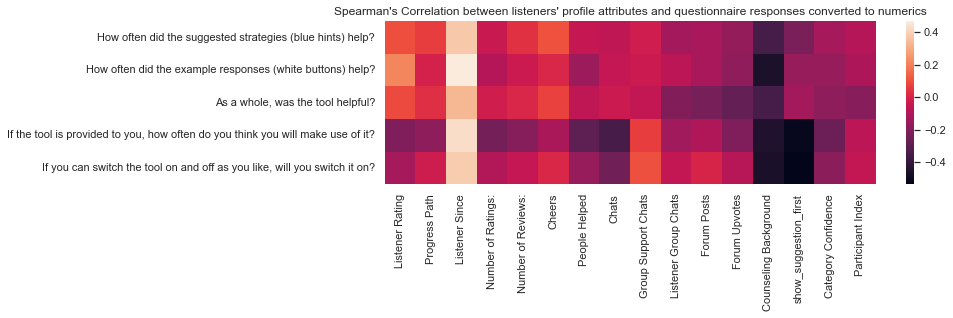

In [126]:
import itertools
from scipy.stats.stats import spearmanr

def compute_num_exp_correlation(df):
    x_columns = NUM_COL_PROFILES + ["Counseling Background", "show_suggestion_first", "Category Confidence", "Participant Index"]
    y_columns = [
        'NUM_EXP_How often did the suggested strategies (blue hints)... [help?]', 
        'NUM_EXP_How often did the example responses (white buttons)... [help?]', 
        'NUM_EXP_As a whole, was the tool... [helpful?]', 
        'NUM_EXP_If the tool is provided to you, how often do you think you will make use of it? [-]', 
        'NUM_EXP_If you can switch the tool on and off as you like, will you switch it on? [-]',
    ]

    correlations = []
    for x, y in itertools.product(x_columns, y_columns):
        r, p = spearmanr(df[x], df[y])
        correlations.append((x.replace(NUM_PREFIX, ""), y.replace(NUM_PREFIX, "").replace(EXP_PREFIX, "").replace(" [-]", "").replace("...", "").replace("[", "").replace("]", ""), r, p))  # remove prefixes for readability

    draw_heatmap(correlations, "Spearman's Correlation between listeners' profile attributes and questionnaire responses converted to numerics", x_columns)

    correlations.sort(key=lambda x: x[-1])
    correlation_df = pd.DataFrame(data=correlations, columns=["Variable from Listener profile", "Variable from questionnaire response", "Spearman correlation coefficient", "Two-tailed p-value"])
    # correlation_df.to_csv("profile-questionnaire-numeric.csv")
    return correlation_df

df = compute_num_exp_correlation(participants)
df.head(5)

### Binary Y

/var/folders/sh/npz3g13d7xv_cgxh2rjw81_w0000gn/T/ipykernel_7935/3663810211.py:2: DeprecationWarning: Please use `spearmanr` from the `scipy.stats` namespace, the `scipy.stats.stats` namespace is deprecated.
  from scipy.stats.stats import spearmanr


,Variable from Listener profile,Variable from questionnaire response,Spearman correlation coefficient,Two-tailed p-value
0,show_suggestion_first,If you can switch the tool on and off as you l...,-0.661438,0.007244
1,Counseling Background,How often did the example responses (white but...,-0.507499,0.053468
2,Counseling Background,If you can switch the tool on and off as you l...,-0.501280,0.056960
3,Listener Since,How often did the suggested strategies (blue h...,0.440959,0.099916
4,Listener Since,"If the tool is provided to you, how often do y...",0.440959,0.099916


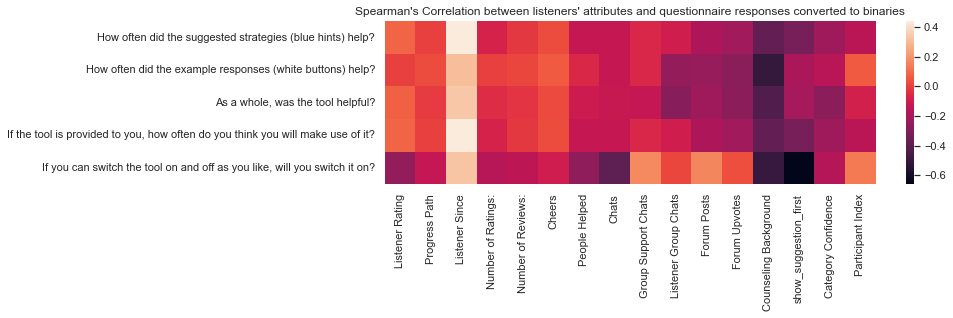

In [84]:
import itertools
from scipy.stats.stats import spearmanr

def compute_bin_exp_correlation(df):
    x_columns = NUM_COL_PROFILES + ["Counseling Background", "show_suggestion_first", "Category Confidence", "Participant Index"]
    y_columns = [
        'BIN_EXP_How often did the suggested strategies (blue hints)... [help?]', 
        'BIN_EXP_How often did the example responses (white buttons)... [help?]', 
        'BIN_EXP_As a whole, was the tool... [helpful?]', 
        'BIN_EXP_If the tool is provided to you, how often do you think you will make use of it? [-]', 
        'BIN_EXP_If you can switch the tool on and off as you like, will you switch it on? [-]',
    ]

    correlations = []
    for x, y in itertools.product(x_columns, y_columns):
        r, p = spearmanr(df[x], df[y])
        correlations.append((x.replace(NUM_PREFIX, ""), y.replace(BIN_PREFIX, "").replace(EXP_PREFIX, "").replace(" [-]", "").replace("...", "").replace("[", "").replace("]", ""), r, p))  # remove prefixes for readability

    draw_heatmap(correlations, "Spearman's Correlation between listeners' attributes and questionnaire responses converted to binaries", x_columns)

    correlations.sort(key=lambda x: x[-1])
    correlation_df = pd.DataFrame(data=correlations, columns=["Variable from Listener profile", "Variable from questionnaire response", "Spearman correlation coefficient", "Two-tailed p-value"])
    # correlation_df.to_csv("profile-questionnaire-binary.csv")
    return correlation_df

df = compute_bin_exp_correlation(participants)
df.head(5)

In [58]:
copy = participants[["NUM_Listener Since", "EXP_As a whole, was the tool... [helpful?]", "OBJ_Listener Since", "Counseling Background", "Chats", "People Helped"]].copy()
copy[copy["Counseling Background"] < 0.5].sort_values("OBJ_Listener Since")

,NUM_Listener Since,"EXP_As a whole, was the tool... [helpful?]",OBJ_Listener Since,Counseling Background,Chats,People Helped
1,-1853,Agree,2017-12-20,0.0,386,210
9,-1026,Disagree,2020-03-26,0.0,2279,322
6,-863,Agree,2020-09-05,0.0,3358,216
14,-123,Agree,2022-09-15,0.0,25,16
13,-82,Agree,2022-10-26,0.0,36,12
11,-55,Agree,2022-11-22,0.0,34,4
